<a href="https://colab.research.google.com/github/MonishSoundarRaj/data_check_generator/blob/main/SDV_Quickstart.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Welcome to the SDV!

The Synthetic Data Vault (SDV) is a Python library designed to be your one-stop shop for creating tabular synthetic data.

In this notebook, we'll demo the basic features of SDV to get you started with creating synthetic data.

_Last Edit: Dec 12, 2023_

# 0. Installation

Install the SDV library.

In [ ]:
%pip install sdv

**Important**: If you're using Google Colab, please restart the runtime by clicking `Runtime` in the top menu bar and then `Restart Session`

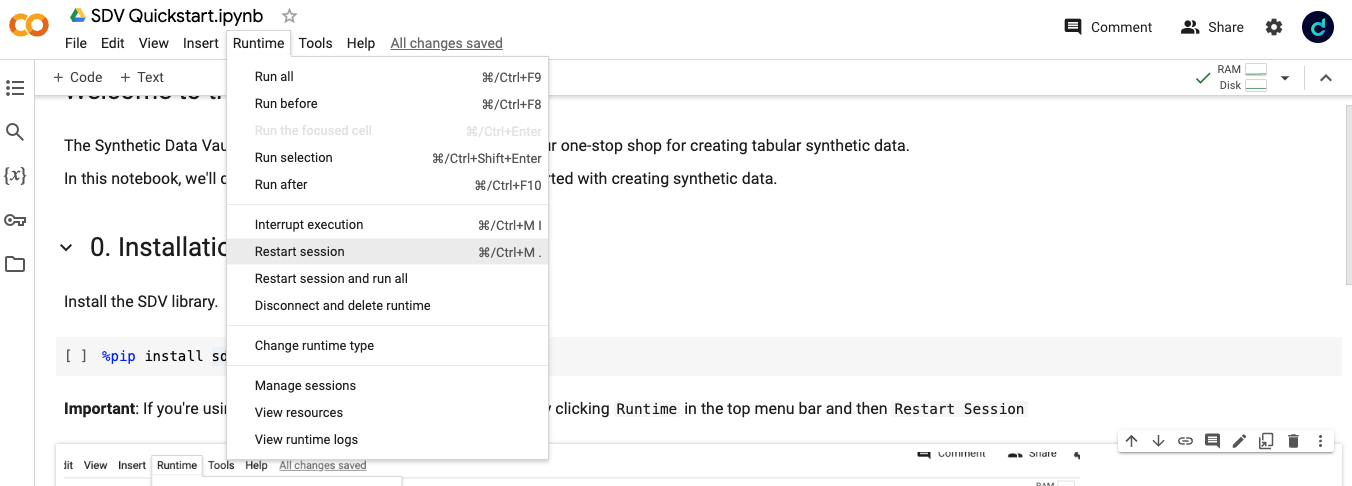

# 1. Loading the data
For this demo, we'll use a fake dataset that describes some fictional guests staying at a hotel.

In [ ]:
from sdv.datasets.demo import download_demo

real_data, metadata = download_demo(
    modality='single_table',
    dataset_name='fake_hotel_guests'
)

**Details**: The data is available as a single table.
- `guest_email` is a _primary key_ that uniquely identifies every row
- Other columns have a variety of data types and some the data may be missing.

In [ ]:
real_data.head()

,guest_email,has_rewards,room_type,amenities_fee,checkin_date,checkout_date,room_rate,billing_address,credit_card_number
0,michaelsanders@shaw.net,False,BASIC,37.89,27 Dec 2020,29 Dec 2020,131.23,"49380 Rivers Street\nSpencerville, AK 68265",4075084747483975747
1,randy49@brown.biz,False,BASIC,24.37,30 Dec 2020,02 Jan 2021,114.43,"88394 Boyle Meadows\nConleyberg, TN 22063",180072822063468
2,webermelissa@neal.com,True,DELUXE,0.00,17 Sep 2020,18 Sep 2020,368.33,"0323 Lisa Station Apt. 208\nPort Thomas, LA 82585",38983476971380
3,gsims@terry.com,False,BASIC,NaN,28 Dec 2020,31 Dec 2020,115.61,"77 Massachusetts Ave\nCambridge, MA 02139",4969551998845740
4,misty33@smith.biz,False,BASIC,16.45,05 Apr 2020,NaN,122.41,"1234 Corporate Drive\nBoston, MA 02116",3558512986488983


The demo also includes **metadata**, a description of the dataset. It includes the primary keys as well as the data types for each column (called "sdtypes").

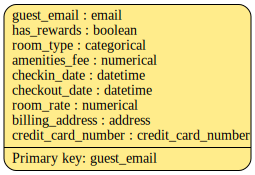

In [ ]:
metadata.visualize()

# 2. Creating a synthesizer

An SDV **synthesizer** is an object that you can use to create synthetic data. It learns patterns from the real data and replicates them to generate synthetic data.

Let's use the `FAST_ML` preset synthesizer, which is optimized for performance.

In [ ]:
from sdv.lite import SingleTablePreset

synthesizer = SingleTablePreset(
    metadata,
    name='FAST_ML'
)

Next, we can **train** the synthesizer. We pass in the real data so it can learn patterns using machine learning.

In [ ]:
synthesizer.fit(
    data=real_data
)

Now the synthesizer is ready to use!

# 3. Generating synthetic data
Use the `sample` function and pass in any number of rows to synthesize.

In [ ]:
synthetic_data = synthesizer.sample(
    num_rows=500
)

synthetic_data.head()

,guest_email,has_rewards,room_type,amenities_fee,checkin_date,checkout_date,room_rate,billing_address,credit_card_number
0,dsullivan@example.net,False,DELUXE,10.385184,03 Apr 2020,23 Apr 2020,149.354932,"90469 Karla Knolls Apt. 781\nSusanberg, CA 70033",5161033759518983
1,steven59@example.org,False,BASIC,NaN,04 Jul 2020,24 Aug 2020,179.634314,"6108 Carla Ports Apt. 116\nPort Evan, MI 71694",4133047413145475690
2,brandon15@example.net,False,BASIC,22.700956,20 Apr 2020,14 Apr 2020,145.658788,86709 Jeremy Manors Apt. 786\nPort Garychester...,4977328103788
3,humphreyjennifer@example.net,False,BASIC,23.497404,20 May 2020,05 Jun 2020,187.945019,"8906 Bobby Trail\nEast Sandra, NY 43986",3524946844839485
4,joshuabrown@example.net,False,DELUXE,20.162318,05 Jan 2020,07 Jan 2020,190.691273,"732 Dennis Lane\nPort Nicholasstad, DE 49786",4446905799576890978


The synthesizer is generating synthetic guests in the **same format as the original data**.

# 4. Evaluating real vs. synthetic data

SDV has built-in functions for evaluating the synthetic data and getting more insight.

## 4.1 Diagnostic

As a first step, we can run a **diagnostic** to ensure that the data is valid. SDV's diagnostic performs some basic checks such as:

- All primary keys must be unique
- Continuous values must adhere to the min/max of the real data
- Discrete columns (non-PII) must have the same categories as the real data
- Etc.

In [ ]:
from sdv.evaluation.single_table import run_diagnostic

diagnostic = run_diagnostic(
    real_data=real_data,
    synthetic_data=synthetic_data,
    metadata=metadata
)

Generating report ...
(2/2) Evaluating Data Structure: : 100%|██████████| 1/1 [00:00<00:00, 165.40it/s]

Overall Score: 100.0%

Properties:
- Data Validity: 100.0%
- Data Structure: 100.0%


<font color="green"><b>The score is 100%</b></font>, indicating that the data is fully valid.

## 4.2 Data Quality

We can also measure the **data quality** or the statistical similarity between the real and synthetic data. This value may vary anywhere from 0 to 100%.

In [ ]:
from sdv.evaluation.single_table import evaluate_quality

quality_report = evaluate_quality(
    real_data,
    synthetic_data,
    metadata
)

Generating report ...
(2/2) Evaluating Column Pair Trends: : 100%|██████████| 36/36 [00:00<00:00, 127.20it/s]

Overall Score: 89.53%

Properties:
- Column Shapes: 91.76%
- Column Pair Trends: 87.29%


According to the score, the synthetic data is about 87% similar to the real data in terms of statistical similarity.

We can also get more details from the report. For example, the Column Shapes sub-score is 92%. Which columns had the highest vs. the lowest scores?

In [ ]:
quality_report.get_details('Column Shapes')

,Column,Metric,Score
0,has_rewards,TVComplement,0.976000
1,room_type,TVComplement,0.914000
2,amenities_fee,KSComplement,0.931136
3,checkin_date,KSComplement,0.934000
4,checkout_date,KSComplement,0.918750
5,room_rate,KSComplement,0.832000


## 4.3 Anonymization

In the original dataset, we had some sensitive columns such as the guest's email, billing address and phone number. In the synthetic data, these columns are **fully anonymized** -- they contain entirely fake values that follow the format of the original.

In [ ]:
sensitive_column_names = ['guest_email', 'billing_address', 'credit_card_number']

real_data[sensitive_column_names].head(3)

,guest_email,billing_address,credit_card_number
0,michaelsanders@shaw.net,"49380 Rivers Street\nSpencerville, AK 68265",4075084747483975747
1,randy49@brown.biz,"88394 Boyle Meadows\nConleyberg, TN 22063",180072822063468
2,webermelissa@neal.com,"0323 Lisa Station Apt. 208\nPort Thomas, LA 82585",38983476971380


In [ ]:
synthetic_data[sensitive_column_names].head(3)

,guest_email,billing_address,credit_card_number
0,dsullivan@example.net,"90469 Karla Knolls Apt. 781\nSusanberg, NC 28401",5161033759518983
1,steven59@example.org,"1080 Ashley Creek Apt. 622\nWest Amy, NM 25058",4133047413145475690
2,brandon15@example.net,"99923 Anderson Trace Suite 861\nNorth Haley, T...",4977328103788


## 4.4 Visualizing the data

For even more insight, we can visualize the real vs. synthetic data.

Let's perform a 1D visualization comparing a column of the real data to the synthetic data.

In [ ]:
from sdv.evaluation.single_table import get_column_plot

fig = get_column_plot(
    real_data=real_data,
    synthetic_data=synthetic_data,
    column_name='amenities_fee',
    metadata=metadata
)

fig.show()

We can also visualize in 2D, comparing the correlations of a pair of columns.

In [ ]:
from sdv.evaluation.single_table import get_column_pair_plot

fig = get_column_pair_plot(
    real_data=real_data,
    synthetic_data=synthetic_data,
    column_names=['checkin_date', 'checkout_date'],
    metadata=metadata
)

fig.show()

# 5. Saving and Loading
We can save the synthesizer to share with others and sample more synthetic data in the future.

In [ ]:
synthesizer.save('my_synthesizer.pkl')

synthesizer = SingleTablePreset.load('my_synthesizer.pkl')

# 6. What's Next?

For more information about the Fast ML preset synthesizer, visit [the documentation](https://docs.sdv.dev/sdv/single-table-data/modeling/synthesizers/fast-ml-preset).

Explore more SDV features through our [other tutorials](https://docs.sdv.dev/sdv/demos).

---

# About

The [Synthetic Data Vault Project](https://github.com/sdv-dev/SDV) was first created at MIT's Data to AI Lab in 2016. After 4 years of research and traction with enterprise, we created [DataCebo](https://datacebo.com/) in 2020 with the goal of growing the project. Today, DataCebo is the proud developer of SDV, the largest ecosystem for tabular synthetic data generation & evaluation.

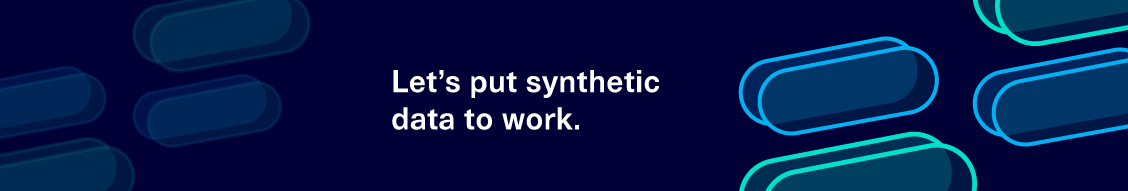